In [1]:
from rdkit import Chem 
import numpy as np
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints.FingerprintMols import GetRDKFingerprint
from rdkit.Chem.Fingerprints.FingerprintMols import FingerprintMol
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import AllChem as convert
from rdkit.Chem.rdMolChemicalFeatures import BuildFeatureFactory 
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect
from rdkit.Chem import Lipinski as l
import pandas as pd
#from oddt.interactions import hbonds
#from oddt.toolkits.ob import Atom
#from rdkit.Chem.Descriptors import FpDensityMorgan1 as morgan\
import rdkit.Chem.Descriptors as desc
from Bio.PDB import PDBParser
#from Bio.PDB.DSSP import DSSP
#from prody import *
import urllib
#from padelpy import padeldescriptor
#from padelpy import from_smiles
from rdkit.Chem import PandasTools
from mordred import Calculator, descriptors
from rdkit.Chem.rdmolfiles import MolFromMol2File
#from rdkit.Chem.ChemicalFeatures import MCFF_GetFeaturesForMol
from rdkit.Chem.EState.EState import EStateIndices
from rdkit.Chem.EState.EState import MaxEStateIndex
from rdkit.Chem.MolDb.FingerprintUtils import BuildMorganFP
from propy import PyPro
from propy.GetProteinFromUniprot import GetProteinSequence
from propy.CTD import CalculateCTD
from propy.AAComposition import CalculateAAComposition

In [2]:
#Accepts array of sdf_file names and name of output csv file(only file name)
def extract_feats(sdf_array,file_name):
    df_main = pd.DataFrame()
    count = 0
    for f in sdf_array:
        count+=1
        df =PandasTools.LoadSDF(f,smilesName="SMILES")
        prot_id_pdb =(df['PDB ID(s) of Target Chain'][1][0:4]).lower()
        uniprot = df['UniProt (SwissProt) Primary ID of Target Chain'][0]
       # try:
            #urllib.request.urlretrieve(f'http://files.rcsb.org/download/{prot}.pdb', f'{prot}.pdb')
            #pdb = f"{prot}.pdb"
        #except:
            #print(f"protien not found in {count} ,use different sdf_file")
            #fetchPDB(prot)
        ID = df['PDB ID(s) for Ligand-Target Complex']
        ligand = df['BindingDB Ligand Name']
        #mol_str =convert.MolFromPDBFile(pdb)
        smiles = np.array(df.SMILES)
        calc = Calculator(descriptors, ignore_3D=True)
        mols = [Chem.MolFromSmiles(smi) for smi in smiles]
        df1 = calc.pandas(mols)
        df_y = df[['Ki (nM)','IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']]
        try:
            proteinsequence = GetProteinSequence(uniprot) 
            protein = GetProteinSequence(ProteinID=uniprot)
            AA_comp = CalculateAAComposition(protein)
            CTD_feats =  CalculateCTD(protein)
            CTD_feats =(pd.DataFrame.from_dict(CTD_feats, orient='index').T)
            AA_comp=(pd.DataFrame.from_dict(AA_comp, orient= 'index').T)
            ''''feat = {    #"FractionCSP3":[l.FractionCSP3(mol_str)],
                        "NHOHCount":[l.NHOHCount(mol_str)],
                        "NOCount": [l.NOCount(mol_str)],
                        "HeavyAtomCount":[l.HeavyAtomCount(mol_str)],
                        "NumAliphaticCarbocycles":[l.NumAliphaticCarbocycles(mol_str)],
                        "NumAliphaticHeterocycles":[l.NumAliphaticHeterocycles(mol_str)],
                        "NumAliphaticRings":[l.NumAliphaticRings(mol_str)],
                        "NumAromaticCarbocycles":[l.NumAromaticCarbocycles(mol_str)],
                        "NumAromaticHeterocycles":[l.NumAromaticHeterocycles(mol_str)],
                        "NumAromaticRings":[l.NumAromaticRings(mol_str)],
                        "NumHAcceptors":[l.NumHAcceptors(mol_str)],
                        "NumHDonors":[l.NumHDonors(mol_str)],
                        "NumHeteroatoms":[l.NumHeteroatoms(mol_str)],
                        "NumRotatableBonds":[l.NumRotatableBonds(mol_str)],
                        "NumSaturatedCarbocycles":[l.NumSaturatedCarbocycles(mol_str)],
                        "NumSaturatedHeterocycles":[l.NumSaturatedHeterocycles(mol_str)],
                        "RingCount":[l.RingCount(mol_str)],
                        "heteratoms" : [convert.CalcNumHeteroatoms(mol_str)],
                        "lipinksiHBA":[convert.CalcNumLipinskiHBA(mol_str)],
                         "TPSA":  [convert.CalcTPSA(mol_str)],
                         "Chi0v" : [convert.CalcChi0v(mol_str)],
                         "Chi3n" :  [convert.CalcChi3n(mol_str)],
                         "chi3v"  : [convert.CalcChi3v(mol_str)],
                         "chi4n"  : [convert.CalcChi4n(mol_str)],
                         "chi4v"   :[convert.CalcChi4v(mol_str)],
                          "morgan1":[desc.FpDensityMorgan1(mol_str)],
                           "morgan2" :[desc.FpDensityMorgan2(mol_str)],
                           "morgan3"  :[desc.FpDensityMorgan3(mol_str)],
                        "Heavyatom_mol_wt":[desc.HeavyAtomMolWt(mol_str)],
                        "MaxAbsPartialCharge":[desc.MaxAbsPartialCharge(mol_str, force=False)],
                        "MaxPartialCharge" :  [desc.MaxPartialCharge(mol_str, force=False)],
                         "MinAbsPartialCharge" :[desc.MinAbsPartialCharge(mol_str, force=False)],
                         "MinPartialCharge"  :  [desc.MinPartialCharge(mol_str, force=False)]}'''

            df2 = pd.concat([CTD_feats,AA_comp],axis=1,ignore_index=True)
            df2['ID'] = ID
            # calculate 147 CTD descriptors
            #pd.concat([df2]*len(smiles-1), ignore_index=True)
            df_repeated = pd.concat([df2]*len(smiles), ignore_index=True)
            df_final =pd.concat([df1,df_repeated],axis=1)
            df_final = pd.concat([df_final,df_y],axis=1)

            df_final['ligand_name'] = ligand
            df_main= pd.concat([df_main,df_final],axis=0)
        except:
            print(f"protien not found in {count} ,use different sdf_file")
            sdf_array.remove(sdf_array[count-1])
            continue
        # download the protein sequence by uniprot id
    df_main.to_csv(f'{file_name}.csv')

                
                
                
                
                
                                                  


In [7]:
import os
from glob import glob
sdf_array =[]
PATH = "prot_ligs_sdf"
EXT = "*.sdf"
all_sdf_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]
len(all_sdf_files)
all_files =list(all_sdf_files)
extract_feats(['1G5S-I17_Validation_Affinities.sdf'],"try")

 54%|█████▍    | 94/173 [00:09<00:10,  7.83it/s]

C:\Users\Administrator\Anaconda3\envs\my-rdkit-env\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 173/173 [00:16<00:00, 10.28it/s]


In [82]:
sdf_arr = ["1G6S-S3P_Validation_Affinities.sdf"]
PandasTools.LoadSDF(sdf_arr)


KeyboardInterrupt: 

In [9]:
sdf_list = ['3MZC-S6I_Validation_Affinities.sdf']
extract_feats(sdf_list , "batman5")

100%|██████████| 65/65 [00:03<00:00, 18.44it/s]


In [43]:
!pip install propy3

In [ ]:
fetchPDB('3eiy')

In [14]:
from biopandas.pdb import PandasPdb
ppdb = PandasPdb().read_pdb('3eiy.pdb.gz')

In [34]:
df =PandasTools.LoadSDF("1ONP-FOM_Validation_Affinities.sdf")
prot =np.array((df['PDB ID(s) of Target Chain'][1][0:4]))

In [36]:
p

array('1JVS', dtype='<U4')

In [73]:
data =pd.read_csv("everything.csv")

C:\Users\Administrator\Anaconda3\envs\my-rdkit-env\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (142,143,151,152,160,161,169,170,178,179,187,188,196,197,205,206,214,215,223,224,232,233,349,350,358,359,367,368,376,377,385,386,394,395,403,404,412,413,421,422,430,431,439,440,448,449,456,457,464,465,472,473,480,481,488,489,496,497,504,505,512,513,520,521,528,529,536,537,544,545,552,553,560,561,568,569,576,577,584,585,592,593,600,601,608,609,616,617,624,625,632,633,640,641,1061,1065,1066,1140,1144,1145,1583,1782,1784,1785) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
ki = data['Ki (nM)']
ki=np.array(ki.fillna(0))
len(np.nonzero(ki)[0])

62

,From,BindingDB Reactant_set_id,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name Assigned by Curator or DataSource,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain,ID,ROMol
0,www.bindingDB.org,51094633,InChI=1S/C15H11NO2/c17-14-12-8-4-5-9-13(12)16(...,SIISFRLGYDVIRG-UHFFFAOYSA-N,22794,"1-benzyl-2,3-dihydro-1H-indole-2,3-dione::Isat...",Aldehyde dehydrogenase (ALDH2),Homo sapiens,15000,,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,14,
1,www.bindingDB.org,51094669,InChI=1S/C13H14N2O3/c16-12-10-3-1-2-4-11(10)15...,ZRUIMDMDIRQCKV-UHFFFAOYSA-N,22841,"1-(morpholin-4-ylmethyl)-2,3-dihydro-1H-indole...",Aldehyde dehydrogenase (ALDH2),Homo sapiens,,>100000,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,61,
2,www.bindingDB.org,51094672,InChI=1S/C17H15NO2/c19-16-14-10-4-5-11-15(14)1...,YDZPVQACTLRICO-UHFFFAOYSA-N,47880,"1-(3-phenylpropyl)indole-2,3-dione::1-(3-pheny...",Aldehyde dehydrogenase (ALDH2),Homo sapiens,,1200,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,2282752,
3,www.bindingDB.org,51094671,InChI=1S/C17H13NO2/c19-16-14-10-4-5-11-15(14)1...,OJMNUQNZECRSCJ-RMKNXTFCSA-N,47902,"1-[(2E)-3-phenylprop-2-enyl]-1H-indole-2,3-dio...",Aldehyde dehydrogenase (ALDH2),Homo sapiens,,>100000,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,2057118,
4,www.bindingDB.org,51094677,InChI=1S/C15H10ClNO2/c16-11-6-7-13-12(8-11)14(...,CCPOUFJZMAONLI-UHFFFAOYSA-N,50133625,"1-Benzyl-5-chloro-1H-indole-2,3-dione::CHEMBL3...",Aldehyde dehydrogenase (ALDH2),Homo sapiens,,2100,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,,
5,www.bindingDB.org,51094667,InChI=1S/C20H21N3O2/c24-19-17-8-4-5-9-18(17)23...,BMIQFAZFVXOTTO-UHFFFAOYSA-N,50448799,CHEMBL3128204,Aldehyde dehydrogenase (ALDH2),Homo sapiens,,>100000,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,,
6,www.bindingDB.org,51094668,InChI=1S/C14H17N3O2/c1-15-6-8-16(9-7-15)10-17-...,IKMDHAUGGJHNHD-UHFFFAOYSA-N,50448800,CHEMBL467080,Aldehyde dehydrogenase (ALDH2),Homo sapiens,,>100000,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,,
7,www.bindingDB.org,51094673,InChI=1S/C16H12BrNO2/c17-12-6-7-14-13(10-12)15...,XMGYGDOAQMLZAW-UHFFFAOYSA-N,50448802,CHEMBL3128207,Aldehyde dehydrogenase (ALDH2),Homo sapiens,,50,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,,
8,www.bindingDB.org,51094674,InChI=1S/C16H12ClNO2/c17-12-6-7-14-13(10-12)15...,LCVZSSKWPJEOMX-UHFFFAOYSA-N,50448803,CHEMBL3128206,Aldehyde dehydrogenase (ALDH2),Homo sapiens,,410,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,,
9,www.bindingDB.org,51094675,InChI=1S/C16H13NO2/c18-15-13-8-4-5-9-14(13)17(...,XICVNIWRISOITG-UHFFFAOYSA-N,50448804,CHEMBL3128205,Aldehyde dehydrogenase (ALDH2),Homo sapiens,,3500,...,P05091,"B4DW54,E7EUE5,Q03639,Q6IB13,Q6IV71",,,,,,,,

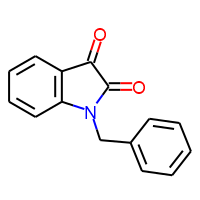
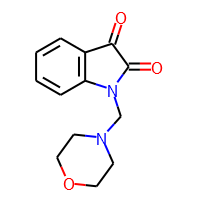
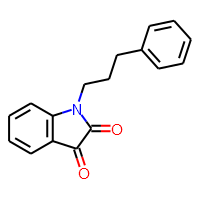
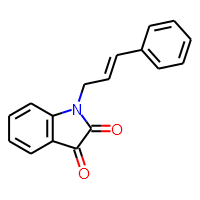
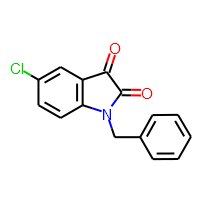
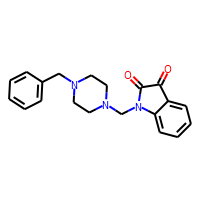
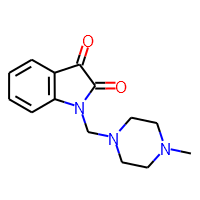
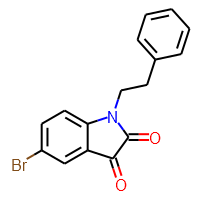
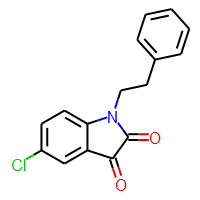
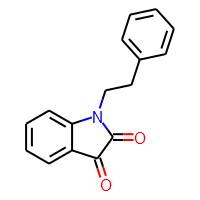
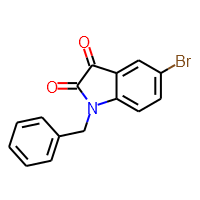
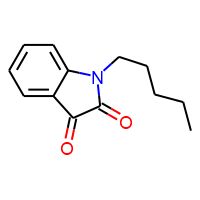

In [5]:
PandasTools.LoadSDF('bind_2.sdf')[]